# [Solved] Lab 5: **Invariance** and **Equivariance** at different layers of a _CNN_

Advanced Topics in Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/solutions/AdvML_UniTS_2023_Lab_05_CNN_Invariance_Equivariance_Solved.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


#### Overview of the _Lab_

In the following _Lab_, we will study the _invariance_ and _equivariance_ properties of specific layers within a _CNN_.

Recall the definitions -- respectively -- of **invariance** and **equivariance** of (the result of) function $f$ with respect to transformation (expressed in the form of an operator) $P_{\alpha}$ parametrized by $\alpha$:

- _Invariance_: $f(P_{\alpha} x) = f(x)\;\;\;\; \forall\alpha$
- _Equivariance_: $f(P_{\alpha} x) = P_{\alpha} f(x)\;\;\;\; \forall\alpha$

According to theory, the training of a _CNN_ with pooling should lead to a network whose:

- _Convolutional_ layers are _equivariant_ to traslation;
- _Fully Connected_ layers are _invariant_ to traslation.

Due to the specific structure of convolutional layers, it is possible to show that the _equivariance_ property gives rise to permuted activations in response to translation of inputs.


In [1]:
from tqdm import trange

import torch as th
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

The following _CNN_ model is given, whose output -- for your convenience -- is a tuple, composed of the actual output of the network, the activation tensor after the second _convolutional_ layer, and the activation tensor after the first _fully-connected_ layer:


In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=2)
        # self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(729, 50)
        # self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        # x = F.max_pool2d(x, 2)
        conv2repr = x.clone().detach()
        x = F.relu(x)
        # x = self.conv2(x)
        # x = F.max_pool2d(x, 2)
        # x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        fc1repr = x.clone().detach()
        # x = F.relu(x)
        # x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x, conv2repr, fc1repr

Taking inspiration from previous _Labs_:

1. Train the model on the (non-augmented) _MNIST_ dataset;
2. Prepare a test dataset composed of pairs of mutually traslated images;
3. Extract the activations of layers `conv2` and `fc1` and check whether they respect the invariance/equivariance property.

**Hint**: To test for _equivariance_, it may be useful to notice that **sorting** is invariant to permutations!


#### Training of the model


In [3]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 7
LEARNING_RATE = 0.01
MOMENTUM = 0.0

In [4]:
# Data-sets/loaders definition
augmentation = transforms.RandomAffine(0, translate=[0, 0.3], scale=None, shear=None)
to_tensor = transforms.ToTensor()
normalization = transforms.Normalize(mean=0.1307, std=0.3081)

# Loading the datasets
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transforms.Compose([to_tensor, normalization]),
    download=True,
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transforms.Compose([to_tensor, normalization]),
    download=True,
)
test_dataset_trsl = datasets.MNIST(
    root="./data",
    train=False,
    transform=transforms.Compose([to_tensor, normalization, augmentation]),
    download=True,
)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader_trsl = DataLoader(
    dataset=test_dataset_trsl, batch_size=BATCH_SIZE, shuffle=False
)

In [5]:
# Model instantiation
model = Model()

# Device selection
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

optimizer = th.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

criterion = nn.NLLLoss()

Using device: cpu


In [6]:
# Some useful functions
def get_batch_accuracy(logit, target):
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, criterion, test_loader, device):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs, _, _ = model(images)
        test_loss += criterion(outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc

In [7]:
model = model.eval()
untrained_loss, untrained_acc = get_test_stats(model, criterion, test_loader, device)
model = model.train()

In [8]:
# Training loop

batch_losses = []

for epoch in trange(EPOCHS):
    model = model.train()

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        logits, _, _ = model(images)
        loss = criterion(logits, labels)

        batch_losses.append(loss.item())  # Store the loss for plotting, per batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 7/7 [00:29<00:00,  4.22s/it]


In [9]:
model.eval()
trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)

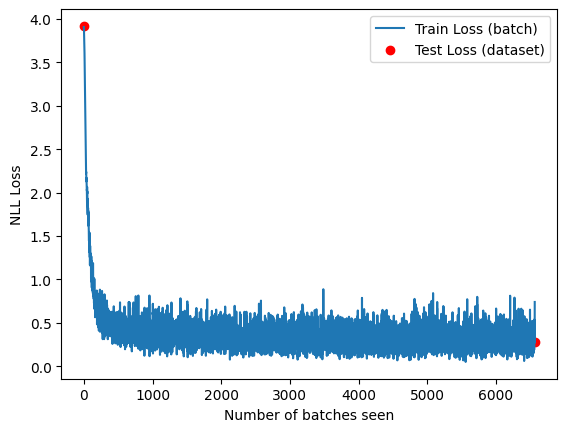

In [10]:
# Plot losses
xrange = range(len(batch_losses))
_ = plt.plot(xrange, batch_losses)
_ = plt.scatter((xrange[0], xrange[-1]), (untrained_loss, trained_loss), color="red")
_ = plt.legend(["Train Loss (batch)", "Test Loss (dataset)"], loc="upper right")
_ = plt.xlabel("Number of batches seen")
_ = plt.ylabel("NLL Loss")

#### Invariance and Equivariance tests


In [11]:
differences_inv = []
differences_eqv = []
differences_inv_control = []
differences_eqv_control = []

control_img = None

model.eval()

for i, (images, label) in enumerate(test_loader):
    # The order is the same due to the fact that both dataloaders are not shuffled!
    (images_trsl, label_trsl) = test_loader_trsl.__iter__().__next__()

    if i == 0:
        control_img = th.randn_like(images).to(device)

    # When the non-augmented dataset is over, the rest of the batch is eventually filled with augmentations
    # This check (and fix) avoids dimension mismatches
    if images.shape[0] != images_trsl.shape[0]:
        images_trsl = images_trsl[: images.shape[0]]
        control_img = control_img[: images.shape[0]]

    images, images_trsl = images.to(device), images_trsl.to(device)

    _, act_eqv, act_inv = model(images)
    _, act_eqv_trsl, act_inv_trsl = model(images_trsl)
    _, act_eqv_control, act_inv_control = model(control_img)

    act_eqv, _ = th.sort(act_eqv.reshape(act_inv.shape[0], -1), dim=1)
    act_eqv_trsl, _ = th.sort(
        act_eqv_trsl.reshape(act_inv.shape[0], -1),
        dim=1,
    )
    act_eqv_control, _ = th.sort(
        act_eqv_control.reshape(act_inv.shape[0], -1),
        dim=1,
    )

    differences_inv.append(act_inv - act_inv_trsl)
    differences_eqv.append(act_eqv - act_eqv_trsl)
    differences_inv_control.append(act_inv - act_inv_control)
    differences_eqv_control.append(act_eqv - act_eqv_control)

    control_img = images_trsl

avg_norm_inv = th.linalg.norm(th.cat(differences_inv, dim=0), dim=1).mean()
avg_norm_eqv = th.linalg.norm(th.cat(differences_eqv, dim=0), dim=1).mean()
avg_norm_inv_control = th.linalg.norm(
    th.cat(differences_inv_control, dim=0), dim=1
).mean()
avg_norm_eqv_control = th.linalg.norm(
    th.cat(differences_eqv_control, dim=0), dim=1
).mean()

print(f"Average Euclidean norm of the difference (invariance): {avg_norm_inv.item()}")
print(f"Average Euclidean norm of the difference (equivariance): {avg_norm_eqv.item()}")
print(
    f"Average Euclidean norm of the difference (invariance, control): {avg_norm_inv_control.item()}"
)
print(
    f"Average Euclidean norm of the difference (equivariance, control): {avg_norm_eqv_control.item()}"
)

Average Euclidean norm of the difference (invariance): 20.73196792602539
Average Euclidean norm of the difference (equivariance): 30.764083862304688
Average Euclidean norm of the difference (invariance, control): 20.780563354492188
Average Euclidean norm of the difference (equivariance, control): 30.96148681640625
